In [2]:
"""
N0 range:[0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50, 100]
gamma range: [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.9]

Número de batalhas: 10k
neptune
Action space: 4 moves + 5 switches
poke-env installed in C:\\Users\\-\\anaconda3\\envs\\poke_env\\lib\\site-packages
"""


'\nN0 range:[0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 2, 5, 10, 25, 50, 100]\nNúmero de batalhas: 10k\nneptune\nAction space: 4 moves + 5 switches\npoke-env installed in C:\\Users\\-\\anaconda3\\envs\\poke_env\\lib\\site-packages\n'

In [14]:
# Imports

import numpy as np

import sys
from gym import spaces
import asyncio
import time

from collections import defaultdict

from src.playerMC import Player as PlayerMC

from poke_env.player.player import Player 
#from poke_env.player.random_player import RandomPlayer

from poke_env.environment.abstract_battle import AbstractBattle

import matplotlib
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)
#loop = asyncio.get_event_loop()
import neptune.new as neptune
run = neptune.init(project='leolellisr/rl-pokeenv',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NjY1YmJkZi1hYmM5LTQ3M2QtOGU1ZC1iZTFlNWY4NjE1NDQifQ==')


https://app.neptune.ai/leolellisr/rl-pokeenv/e/RLPOK-30
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [15]:
def name_to_id(name):
    if(name == 'venusaur'): return 0
    if(name == 'pikachuoriginal'): return 1 
    if(name == 'tauros'): return 2 
    if(name == 'sirfetchd'): return 3 
    if(name == 'blastoise'): return 4 
    if(name == 'charizard'): return 5 

In [16]:
class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        # If the player can attack, it will
        if battle.available_moves:
            # Finds the best move among available ones
            #print(battle.available_moves[0])
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            return self.create_order(best_move)

        # If no attack is available, a random switch will be made
        else:
            return self.choose_random_move(battle)

In [17]:
class MCPlayer(PlayerMC):
    def choose_move(self, battle):
        # In the 1st state of all we don't append yet;
        # Other states: using previous state and action with actual reward (actual battle) 
        if self.previous_action != -10: self.episode.append((self.previous_state, self.previous_action, self.compute_reward(battle)))
            
        # Getting state s (-> embed battle)
        s = self.embed_battle(battle)
        # 1st move will be random wout policy    
        if(self.aux == 0):
            self.aux = 1
            action = np.random.choice(self.action_space)

        # Other moves have policy    
        else: action = np.random.choice(self.action_space, p=self.policy(s))

        # Saving action and state to append later. We can compute the reward only after the move    
        self.previous_action = action
        self.previous_state = s

        # Prints for debuging    
        #print(battle.available_moves)
        #print(f"Choosed action int: {action}")        
        #print("Return: ", self.policy(s))

        # Choose move according to action index
        if action == -1:
            return ForfeitBattleOrder()
        elif (
            action < 4
            and action < len(battle.available_moves)
            and not battle.force_switch
        ):
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)
        
        return self.create_order(action)

    # the embed battle is our state
    # 10 factors: 4 moves base power, 4 moves multipliers, active pokemon and active opponent pokemon 
    def embed_battle(self, battle):
        # -1 indicates that the move does not have a base power or not available
        active_pokemon = [mon for mon in battle.team.values() if mon._active]
        name_id = name_to_id(active_pokemon[0]._species)
        #print(active_pokemon)
        
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling 
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # how many pokemons have fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )

        # Final vector with 10 components
        x = np.around(np.concatenate(
            [
                 np.array([name_id]), moves_base_power,
                moves_dmg_multiplier,
                [remaining_mon_team, remaining_mon_opponent]
            ])
        ,decimals=2)
        
        # Convert to string so we can use as hash
        return ' '.join(str(i) for i in x)
        

    # Computing rewards
    def reward_computing_helper(
        self,
        battle: AbstractBattle,
        *,
        fainted_value: float = 0.15, 
        hp_value: float = 0.15,      
        number_of_pokemons: int = 6,
        starting_value: float = 0.0,
        status_value: float = 0.15, 
        victory_value: float = 1.0
    ) -> float:
        
        # 1st compute
        if battle not in self._reward_buffer:
            self._reward_buffer[battle] = starting_value
        current_value = 0
        
        # Verify if pokemon have fainted or have status
        for mon in battle.team.values():
            current_value += mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value -= fainted_value
            elif mon.status is not None:
                current_value -= status_value

        current_value += (number_of_pokemons - len(battle.team)) * hp_value

        # Verify if opponent pokemon have fainted or have status
        for mon in battle.opponent_team.values():
            current_value -= mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value += fainted_value
            elif mon.status is not None:
                current_value += status_value

        current_value -= (number_of_pokemons - len(battle.opponent_team)) * hp_value

        # Verify if we won or lost
        if battle.won:
            current_value += victory_value
        elif battle.lost:
            current_value -= victory_value

        # Value to return
        to_return = current_value - self._reward_buffer[battle]
        self._reward_buffer[battle] = current_value
        #self.reward_per_battle.append(current_value)
        #print(self.reward_per_battle)
        run[f'N0: {self.n0} reward_buffer'].log(current_value)
        run[f'N0: {self.n0} reward returned'].log(to_return)
        return to_return
    
    
    # Calling reward_computing_helper
    def compute_reward(self, battle) -> float:
        return self.reward_computing_helper(            
            battle, fainted_value=2, hp_value=1, status_value=1, victory_value=15
        )

    # Battle (episode) has finished
    def _battle_finished_callback(self, battle):
        reward_array = [reward for state,action,reward in self.episode]
        t_array = range(len(self.episode))
        returnGt = sum([reward*pow(self.gamma, t) for reward, t in zip(reward_array, t_array)]) 
        run[f'N0: {self.n0} gamma: {self.gamma} Gt'].log(returnGt)
        
        # Computing Q and N
        for state,action,reward in self.episode:
            
            if state not in self.visited_states:
                self.N[state][action] += 1
                # incremental update of Q value is more efficient than keeping a record of all rewards
                # and averaging after every new reward
                run[f'N0: {self.n0} gamma: {self.gamma} reward computed'].log(reward)
                # discount_factor = 1; step-size: 1./N[state][action]
                self.Q[state][action] += self.discount_factor * ( 1./ self.N[state][action] ) * (returnGt - self.Q[state][action]) 
                run[f'N0: {self.n0} gamma: {self.gamma} q_value'].log(self.Q[state][action])
                self.visited_states.append(state)
                
        self.visited_states = []
        if(self.aux == 1):
            self.aux == 0
            
        # Define new policy with updated Q and N
        self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)
        run[f'N0: {self.n0} gamma: {self.gamma} win_acc'].log(self.n_won_battles/len(self._reward_buffer))
        
# We evaluate the performance on mon_a against mon_b as its type advantage
    def teampreview_performance(self, mon_a, mon_b):    
        a_on_b = b_on_a = -np.inf
        for type_ in mon_a.types:
            if type_:
                a_on_b = max(a_on_b, type_.damage_multiplier(*mon_b.types))
        # We do the same for mon_b over mon_a
        for type_ in mon_b.types:
            if type_:
                b_on_a = max(b_on_a, type_.damage_multiplier(*mon_a.types))
        # Our performance metric is the different between the two
        return a_on_b - b_on_a    
    
    # Teampreview (Before battle starts)
    def teampreview(self, battle):
        mon_performance = {}

        # For each of our pokemons
        for i, mon in enumerate(battle.team.values()):
            # We store their average performance against the opponent team
            mon_performance[i] = np.mean(
                [
                    self.teampreview_performance(mon, opp)
                    for opp in battle.opponent_team.values()
                ]
            )
        
        # We sort our mons by performance
        ordered_mons = sorted(mon_performance, key=lambda k: -mon_performance[k])
        
        # We start with the one we consider best overall
        # We use i + 1 as python indexes start from 0
        #  but showdown's indexes start from 1
        return "/team " + "".join([str(i + 1) for i in ordered_mons])

In [18]:
our_team = """
Pikachu-Original (M) @ Light Ball  
Ability: Static  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Volt Tackle  
- Nuzzle  
- Iron Tail  
- Knock Off  

Charizard @ Life Orb  
Ability: Solar Power  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Flamethrower  
- Dragon Pulse  
- Roost  
- Sunny Day  

Blastoise @ White Herb  
Ability: Torrent  
EVs: 4 Atk / 252 SpA / 252 Spe  
Mild Nature  
- Scald  
- Ice Beam  
- Earthquake  
- Shell Smash  

Venusaur @ Black Sludge  
Ability: Chlorophyll  
EVs: 252 SpA / 4 SpD / 252 Spe  
Modest Nature  
IVs: 0 Atk  
- Giga Drain  
- Sludge Bomb  
- Sleep Powder  
- Leech Seed  

Sirfetch’d @ Aguav Berry  
Ability: Steadfast  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Close Combat  
- Swords Dance  
- Poison Jab  
- Knock Off  

Tauros (M) @ Assault Vest  
Ability: Intimidate  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Double-Edge  
- Earthquake  
- Megahorn  
- Iron Head  
"""

In [19]:
op_team = """
Eevee @ Eviolite  
Ability: Adaptability  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Quick Attack  
- Flail  
- Facade  
- Wish  

Vaporeon @ Leftovers  
Ability: Hydration  
EVs: 252 HP / 252 Def / 4 SpA  
Bold Nature  
IVs: 0 Atk  
- Scald  
- Shadow Ball  
- Toxic  
- Wish  

Sylveon @ Aguav Berry  
Ability: Pixilate  
EVs: 252 HP / 252 SpA / 4 SpD  
Modest Nature  
IVs: 0 Atk  
- Hyper Voice  
- Mystical Fire  
- Psyshock  
- Calm Mind  

Jolteon @ Assault Vest  
Ability: Quick Feet  
EVs: 252 SpA / 4 SpD / 252 Spe  
Timid Nature  
IVs: 0 Atk  
- Thunderbolt  
- Hyper Voice  
- Volt Switch  
- Shadow Ball  

Leafeon @ Life Orb  
Ability: Chlorophyll  
EVs: 252 Atk / 4 SpD / 252 Spe  
Adamant Nature  
- Leaf Blade  
- Knock Off  
- X-Scissor  
- Swords Dance  

Umbreon @ Iapapa Berry  
Ability: Inner Focus  
EVs: 252 HP / 4 Atk / 252 SpD  
Careful Nature  
- Foul Play  
- Body Slam  
- Toxic  
- Wish  
"""

In [21]:
# n0_range: N0 values that will be used in our policy function: epsilon = n0/(n0+np.sum(N[state]))
# n_battles: list of number of battles (episodes) that will be played.

n0_range = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.75, 1, 2, 5, 10, 25, 50, 100]
n0_range_array = n0_range*len(gamma_range)
gamma_range = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.9]
gamma_array = gamma_range*len(n0_range)
gamma_array.sort()
n0_range_array.sort()
n_battles = [10000 for n0 in n0_range_array] #all tests have 100 battles; Can be modified to different values (must have same shape)
our_team_array = [our_team for n0 in n0_range_array] #all teams are the same; Can be modified to different teams (must have same shape)
op_team_array = [op_team for n0 in n0_range_array] #all opponents are the same; Can be modified to different teams (must have same shape)

tests =[ {'n0': n0,
          'gamma': gamma,
          'n_battles':n_battle,
          'team':our_team,
          'against':op_team,
          'battle_format':"gen8ou"}
        for n0,gamma,n_battle,our_team,op_team in zip(n0_range_array,gamma_array,n_battles,our_team_array,op_team_array)]


In [22]:
len(tests)

120

In [ ]:
for test in tests:
    
    start = time.time()
    run['params'] = test
    test['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=test['against'])
    test['player'] = MCPlayer(battle_format="gen8ou", team=test['team'], n0=test['n0'], gamma=test['gamma'])
    await test['player'].battle_against(test['opponent'], n_battles=test['n_battles'])
    
    print(
        "Our player with N0=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 2),
            test['player'].n_won_battles,
            len(test['player']._reward_buffer),
            round(test['player'].n_won_battles/len(test['player']._reward_buffer)*100, 2),
            round(time.time() - start, 2)
        )
    )
    


In [ ]:
run.stop()

In [7]:
# Have to wait until done is True
#print(f"done: {x.done()}")


In [11]:
"""
no need with neptune
import statistics
"""

In [14]:
"""
no need with neptune
for test in tests:

    step = 10
    exps=range(len(test['player']._reward_buffer))
    mean_rewards = []
    dv_rewards = []
    exps_s = []
    mean_rewards.append(0)
    dv_rewards.append(0)
    exps_s.append(0)

    for st in range(step):

        n0 = int(st*len(test['player']._reward_buffer)/step)
        n1 = int(n0+len(test['player']._reward_buffer)/step)
        exps_s.append(n1)
        am_rewards = []
        max_rewards = 0
        max_exp_rew = 0

        #if(debug): print(f"n0: {n0} n1: {n1}")
        for n in range(n0,n1):
            #if(debug): print(n)
            am_rewards.append(test['player']._reward_buffer[n])
            if env_player.all_rewards[n] > max_rewards: 
                max_rewards = test['player']._reward_buffer[n]
                max_exp_rew = exps[n]
        mean_rewards.append(int(statistics.mean(am_rewards)))
        dv_rewards.append(int(statistics.stdev(am_rewards)))

    print(f"Max. reward: {max_rewards} Exp: {max_exp_rew}")
    #print(exps_s)


    plt.figure(figsize=(15,10))

    #fig, axes = plt.subplots(6, 3, figsize=(30, 30))
    fig, ax1 = plt.subplots(figsize=(15, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Experimento')

    #ax1.set_xticks(exps_s)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel('Recompensas', color=color)  # we already handled the x-label with ax1
    ax1.plot(exps_s, mean_rewards, 'b:') #color=color
    plt.fill_between(exps_s,np.array(mean_rewards)-np.array(dv_rewards)/2,np.array(mean_rewards)+np.array(dv_rewards)/2,alpha=.1, color=color)
    plt.show()
"""

'\nno need with neptune\nfor test in tests:\n\n    step = 10\n    exps=range(len(test[\'player\']._reward_buffer))\n    mean_rewards = []\n    dv_rewards = []\n    exps_s = []\n    mean_rewards.append(0)\n    dv_rewards.append(0)\n    exps_s.append(0)\n\n    for st in range(step):\n\n        n0 = int(st*len(test[\'player\']._reward_buffer)/step)\n        n1 = int(n0+len(test[\'player\']._reward_buffer)/step)\n        exps_s.append(n1)\n        am_rewards = []\n        max_rewards = 0\n        max_exp_rew = 0\n\n        #if(debug): print(f"n0: {n0} n1: {n1}")\n        for n in range(n0,n1):\n            #if(debug): print(n)\n            am_rewards.append(test[\'player\']._reward_buffer[n])\n            if env_player.all_rewards[n] > max_rewards: \n                max_rewards = test[\'player\']._reward_buffer[n]\n                max_exp_rew = exps[n]\n        mean_rewards.append(int(statistics.mean(am_rewards)))\n        dv_rewards.append(int(statistics.stdev(am_rewards)))\n\n    print(f

Today's date: 2021-10-10


In [42]:
# Saving Q and N to txt files


In [43]:
import re
from datetime import date
today = date.today()
for test in tests:
    qstore = test['player'].Q
    today_s = str(date.today())
    n0_s = str(round(test['n0'],2))
    acc_s = str(round(test['player'].n_won_battles/len(test['player']._reward_buffer)*100))
    battle_s = str(len(test['player']._reward_buffer))
    filename = today_s+"_Q_MCControl_n0_"+n0_s+"_Acc_"+acc_s+"_of_"+battle_s+"_battles_maxnerf"
    filename_txt=re.sub(r'(?<=\d)[,\.-]','',filename)+".txt"
    file = open(filename_txt, "w")
    strig = repr(qstore)
    file.write(filename +" "+ strig + "\n") 

In [44]:
for test in tests:
    nstore = test['player'].N
    today_s = str(date.today())
    n0_s = str(round(test['n0'],2))
    acc_s = str(round(test['player'].n_won_battles/len(test['player']._reward_buffer)*100))
    battle_s = str(len(test['player']._reward_buffer))
    filename = today_s+"_N_MCControl_n0_"+n0_s+"_Acc_"+acc_s+"_of_"+battle_s+"_battles_maxnerf"
    filename_txt=re.sub(r'(?<=\d)[,\.-]','',filename)+".txt"
    file = open(filename_txt, "w")
    strig = repr(nstore)
    file.write(filename +" "+ strig + "\n") 

In [46]:
file.close()

In [ ]:
# state is 4 moves_base_power, 4 moves_dmg_multiplier, [remaining_mon_team, remaining_mon_opponent]
# 3D graph: X: sum(moves_base_power * moves_dmg_multiplier), Y: remaining_mon_team - remaining_mon_opponent

In [19]:
# Not working
"""
def plot_value_function(V, z_plot, title="Value Function"):
   
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z = np.apply_along_axis(lambda _: V[(_[0], _[1])], 2, np.dstack([X, Y]))
    #Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
        ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
        ax.set_zlabel('Value')
        ax.set_title(title)
        #ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, z_plot, "{}".format(title))
"""

In [15]:
"""
def simple_plot(V, title="Value Function"):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
"""    

In [50]:
# Data for plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
i = 0

for test in tests:
    z_values = []
    x_values = []
    y_values = []
    for state, actions in test['player'].Q.items():
        action_value = np.max(actions)
        z_values.append(action_value)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[0]*20+key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    test["vfunction"] = (x_values, y_values, z_values)
#plot_value_function(V, title="Optimal Value Function")

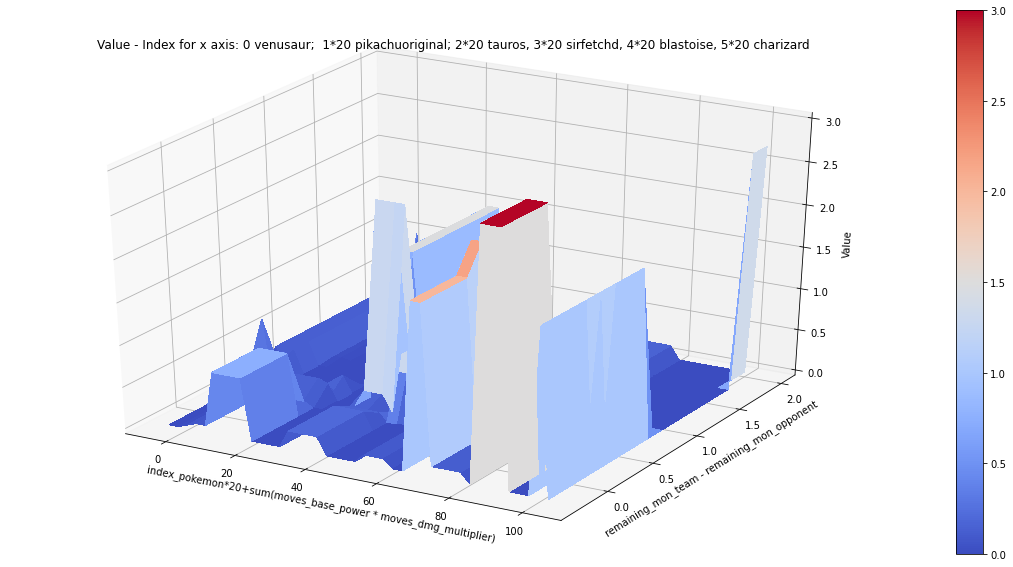

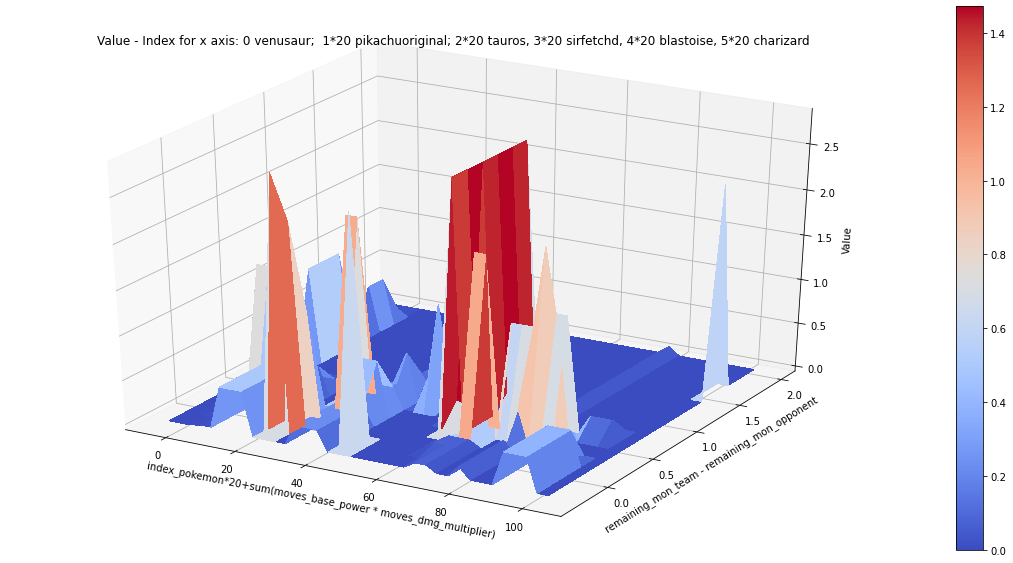

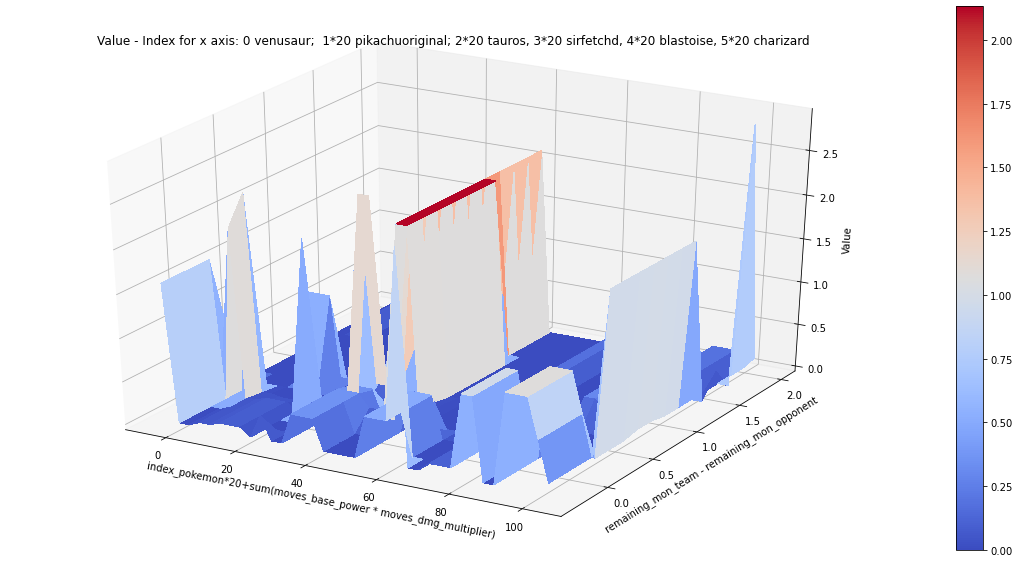

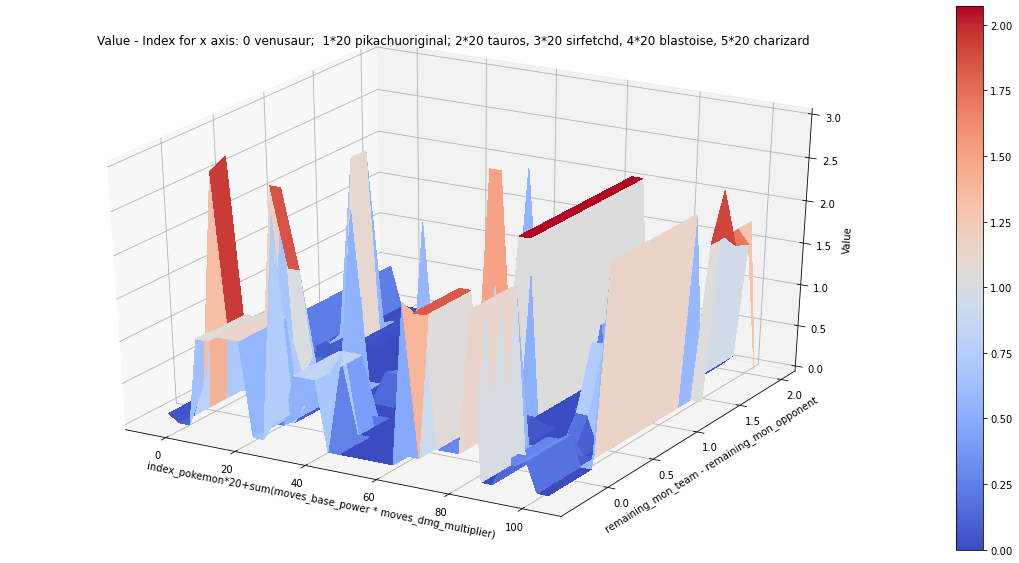

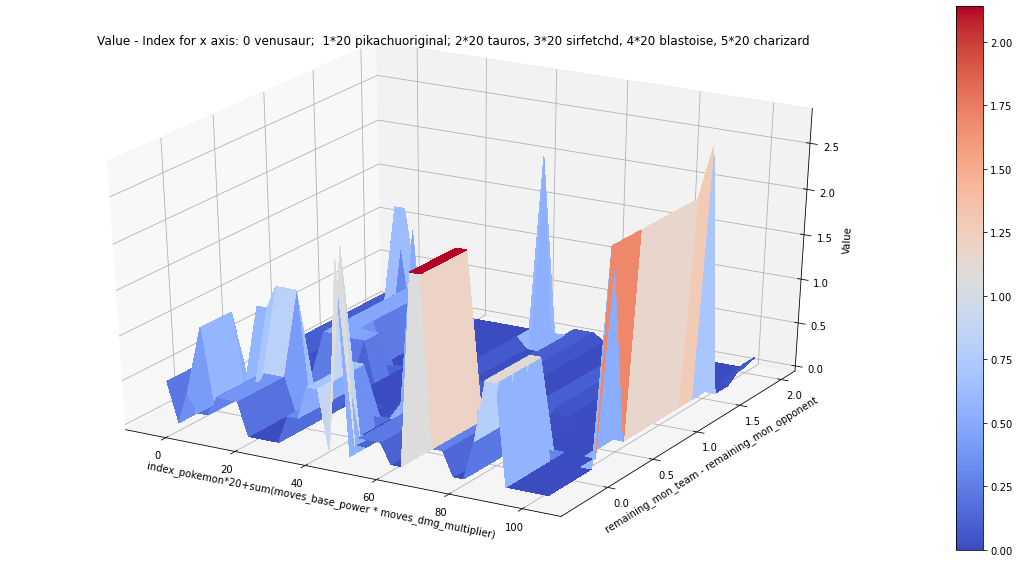

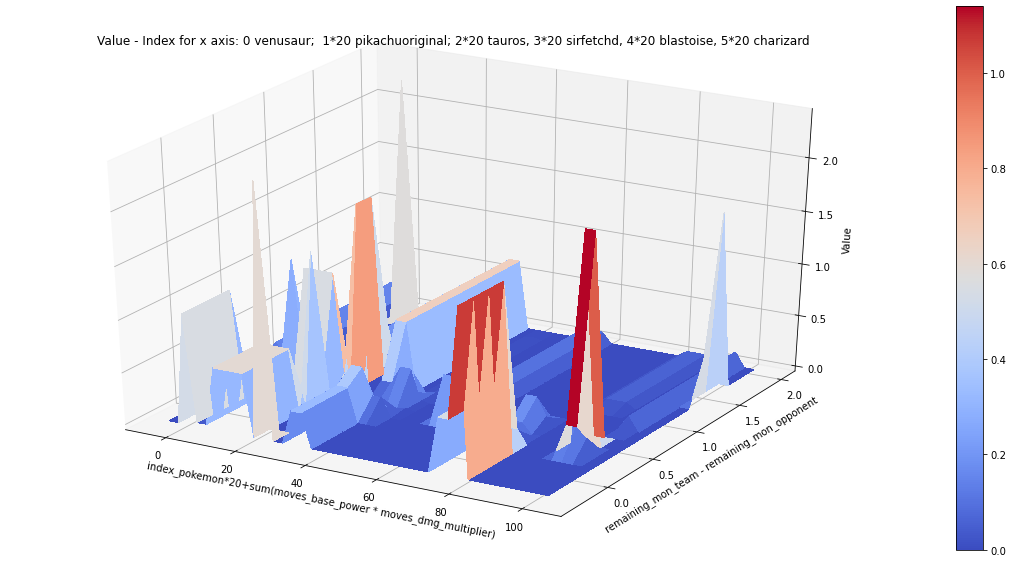

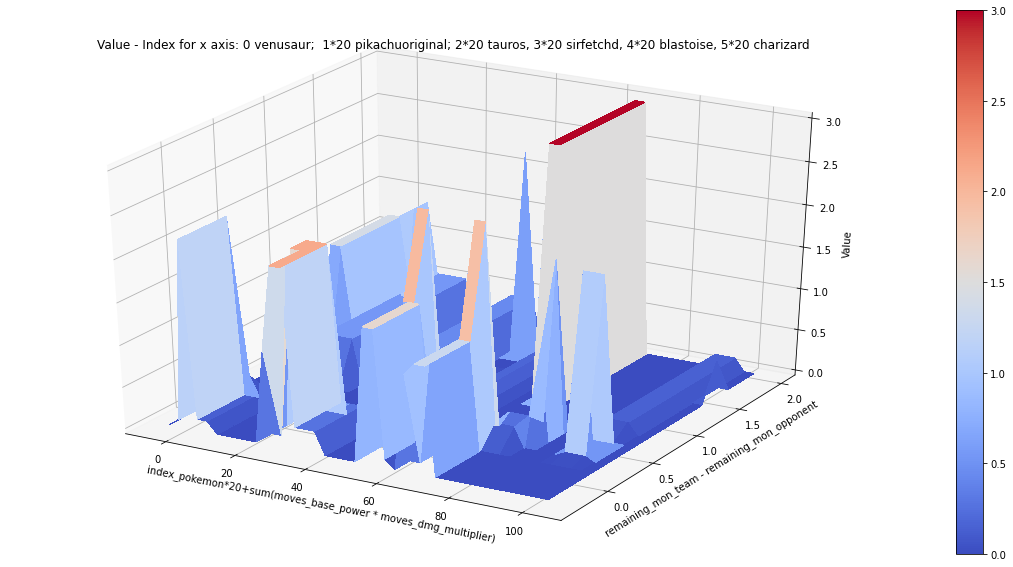

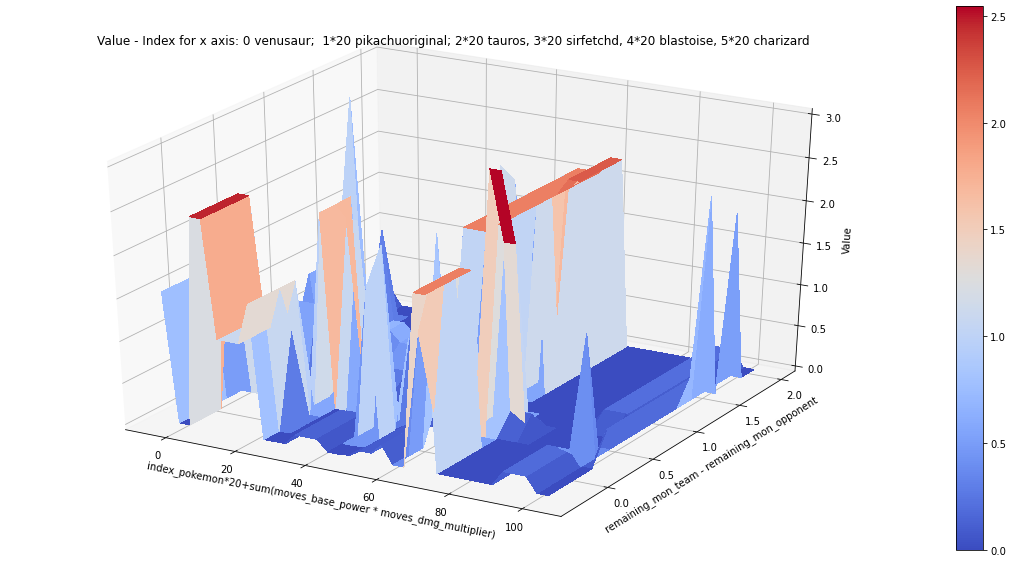

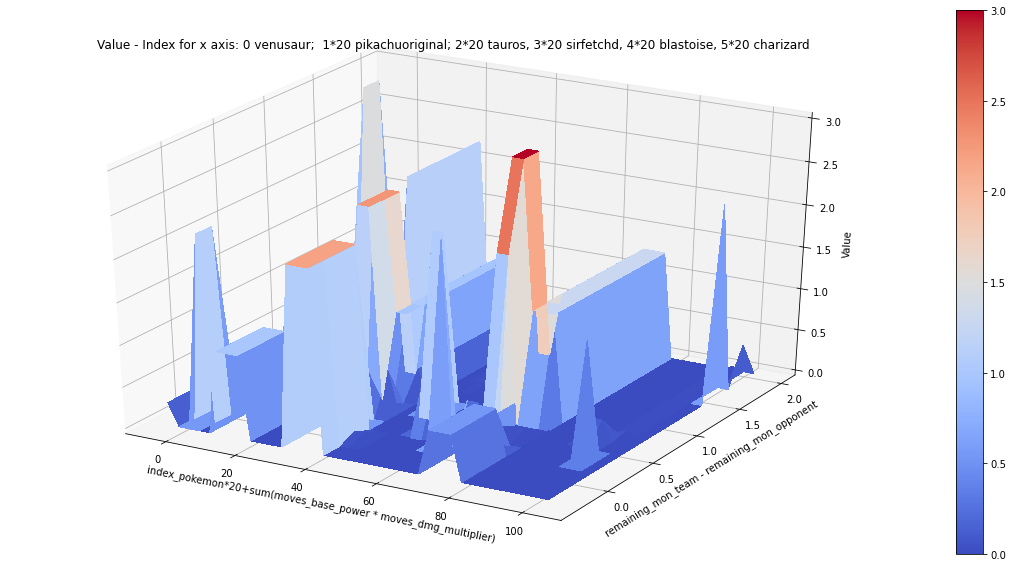

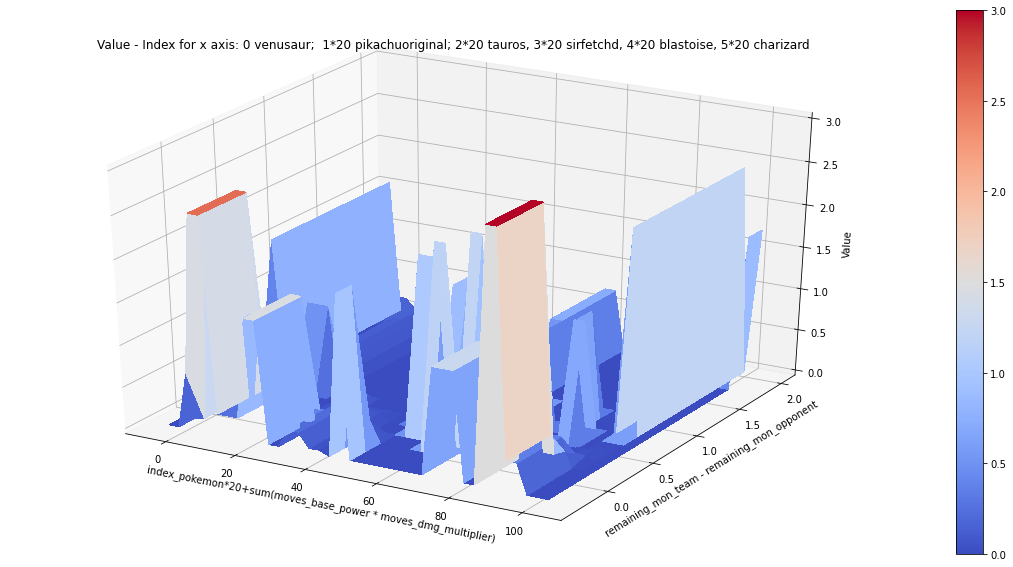

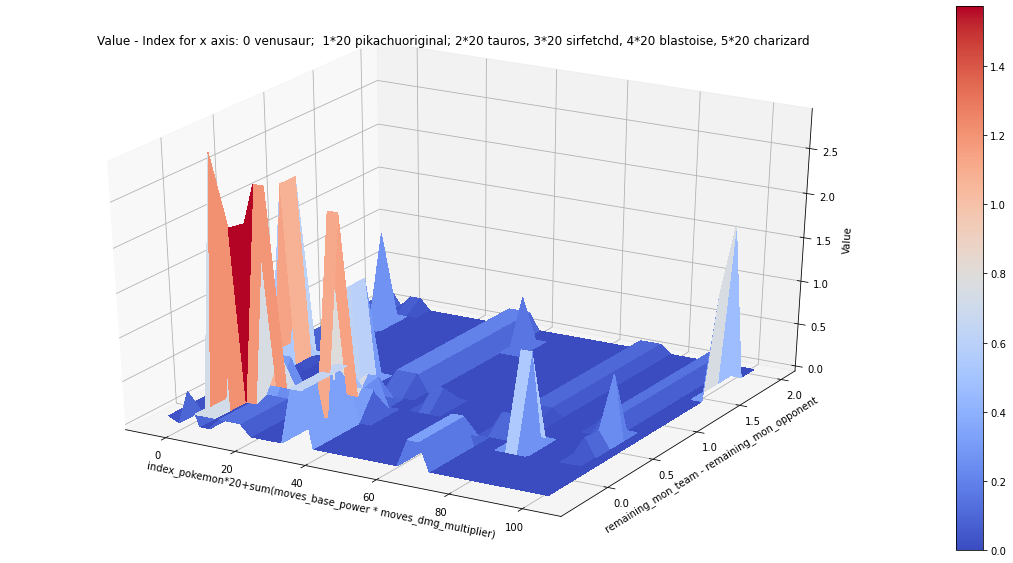

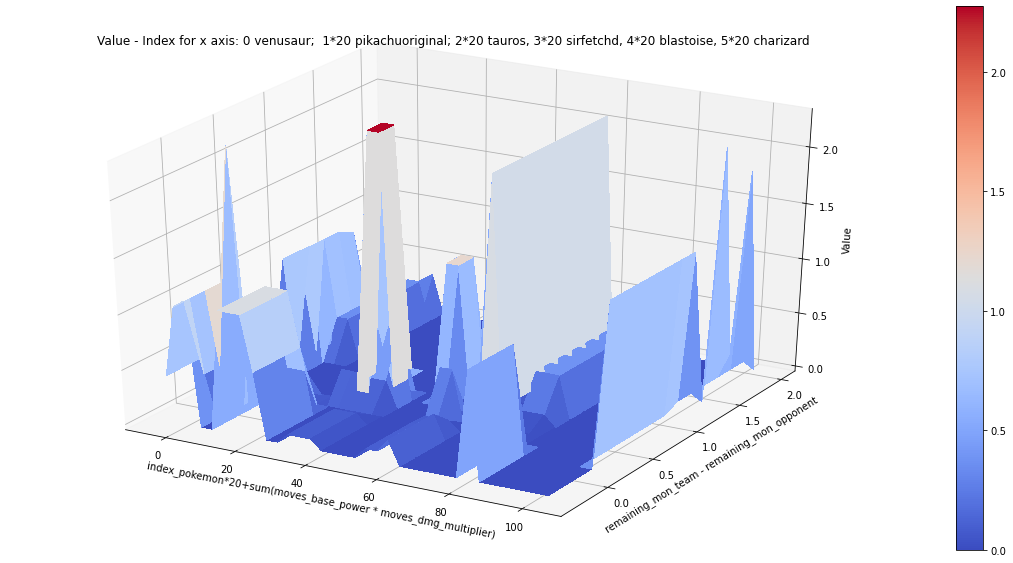

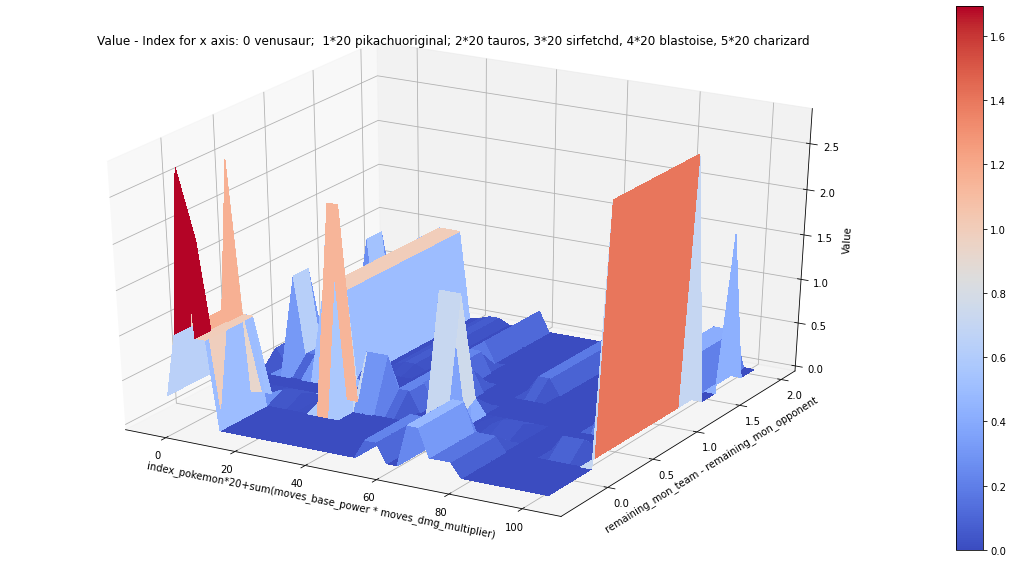

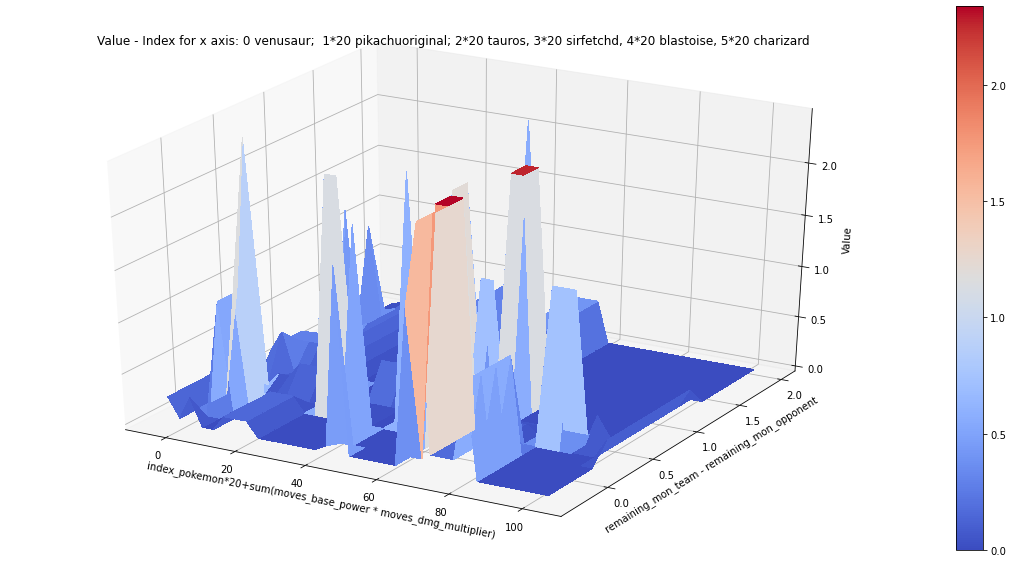

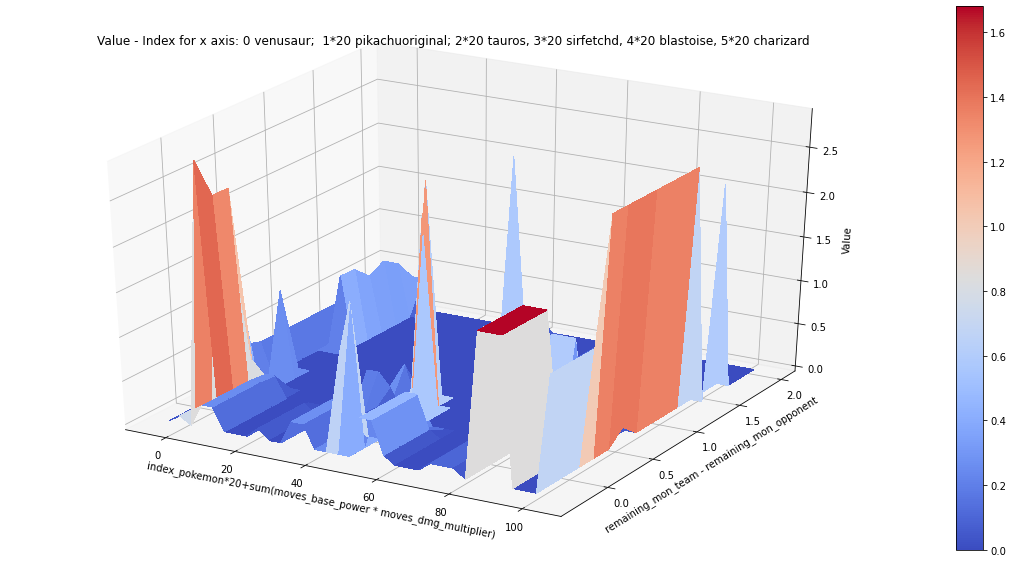

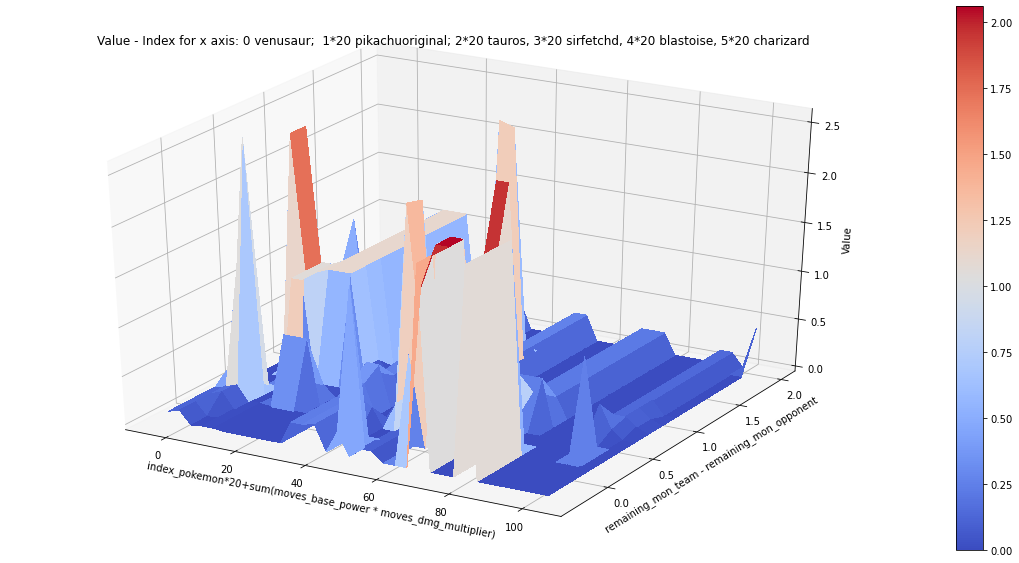

In [58]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for test in tests:
    x_values, y_values, z_values = test["vfunction"] 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - Index for x axis: 0 venusaur;  1*20 pikachuoriginal; 2*20 tauros, 3*20 sirfetchd, 4*20 blastoise, 5*20 charizard')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    
    plt.show()

In [61]:
# sem index - data for plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
i = 0

for test in tests:
    z_values = []
    x_values = []
    y_values = []
    for state, actions in test['player'].Q.items():
        action_value = np.max(actions)
        z_values.append(action_value)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        V[x_emb,y_emb] = action_value
    test["noindex_function"] = (x_values, y_values, z_values)
#plot_value_function(V, title="Optimal Value Function")

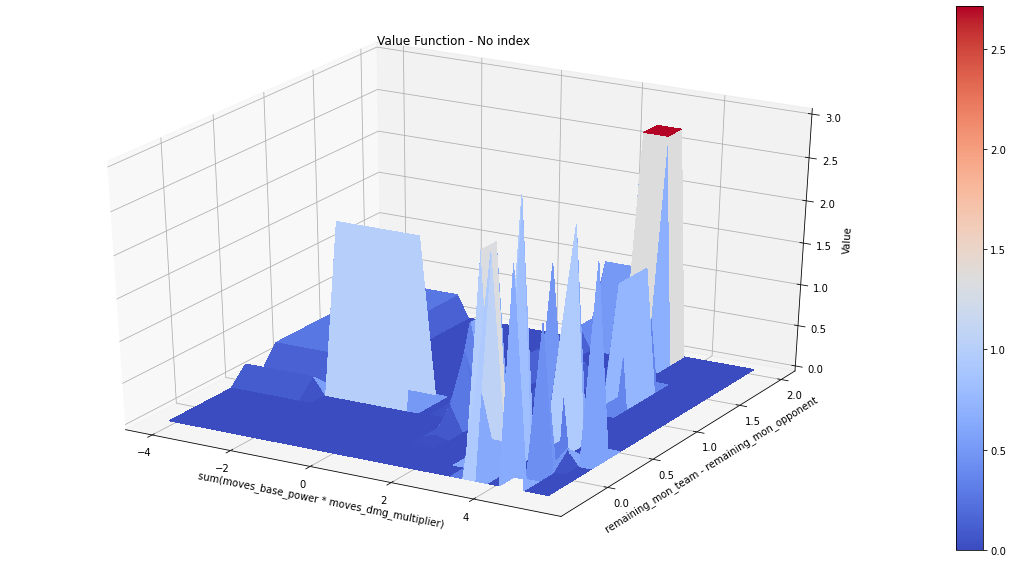

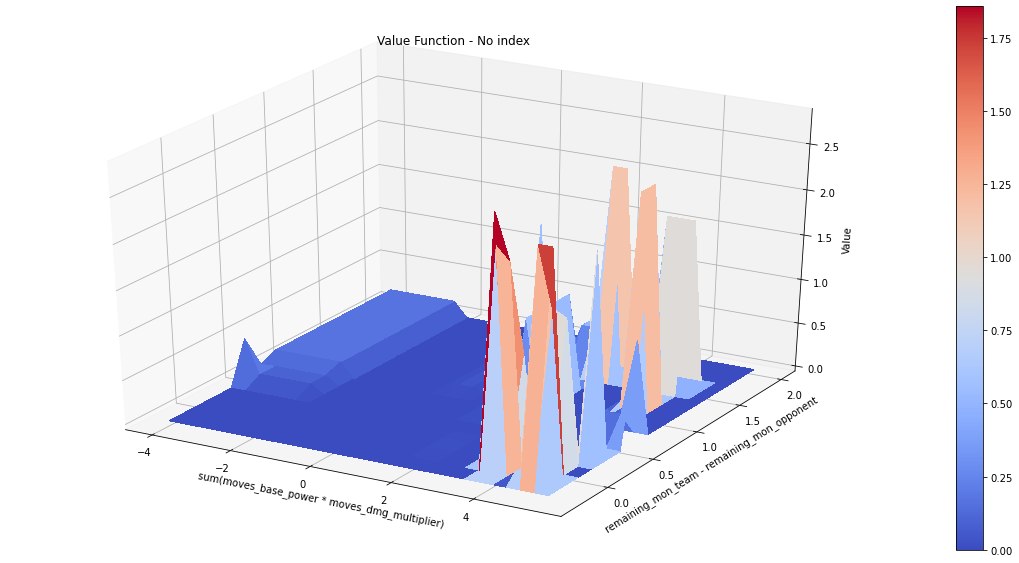

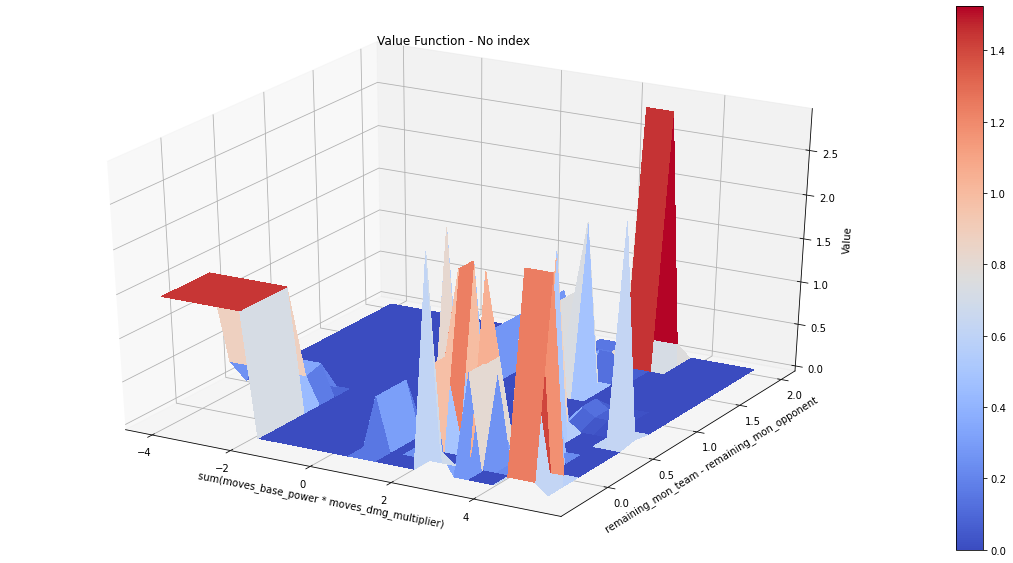

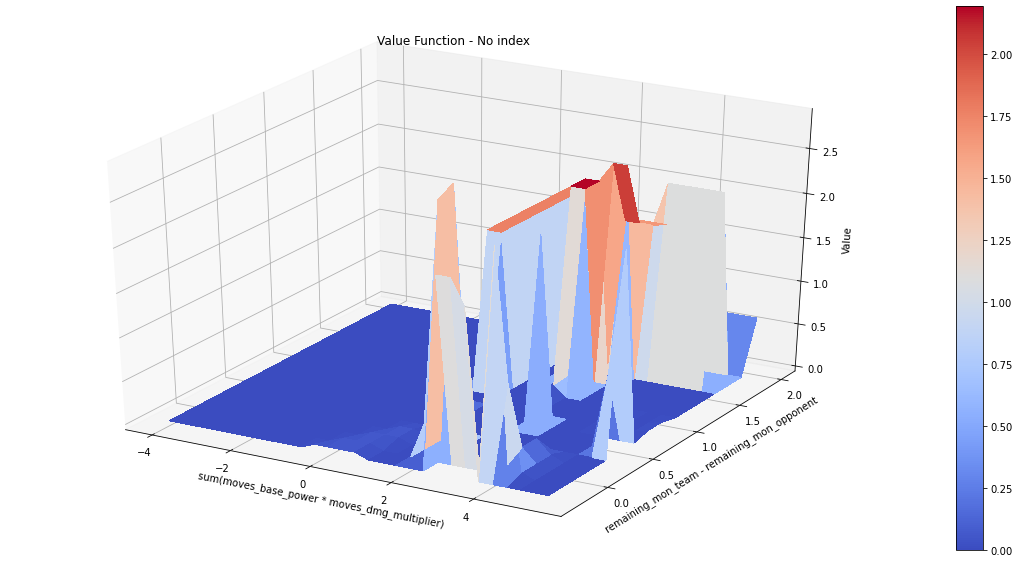

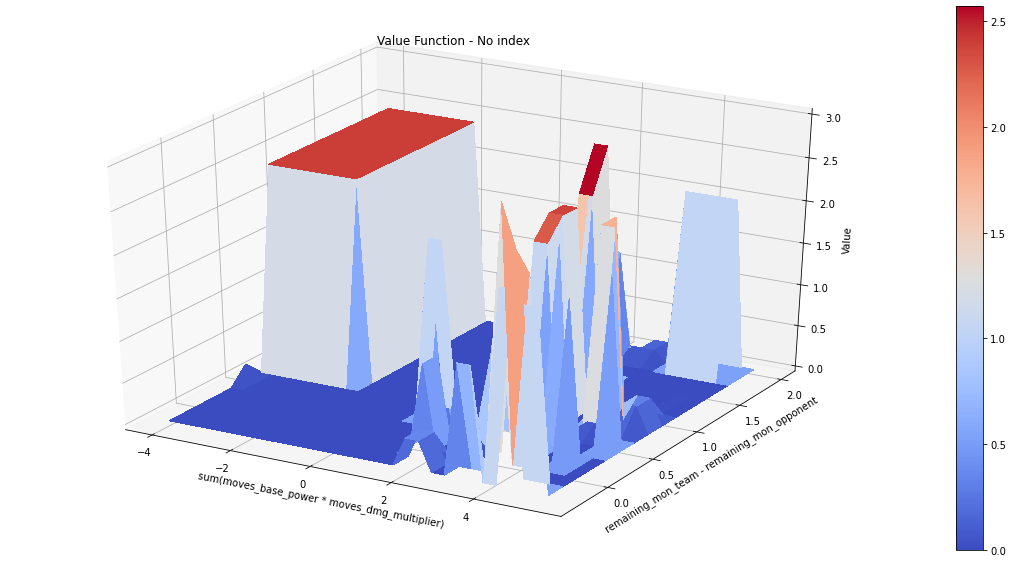

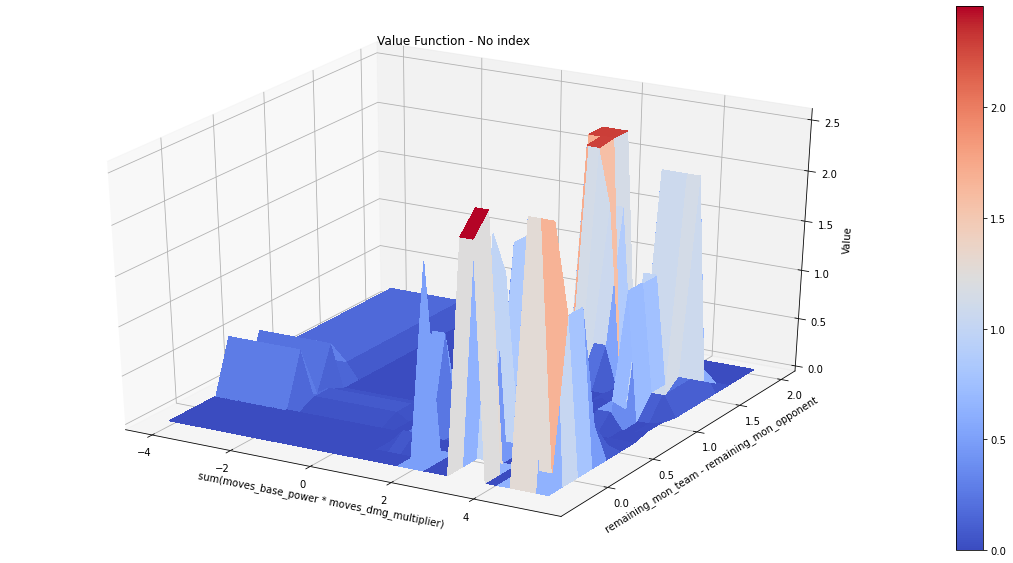

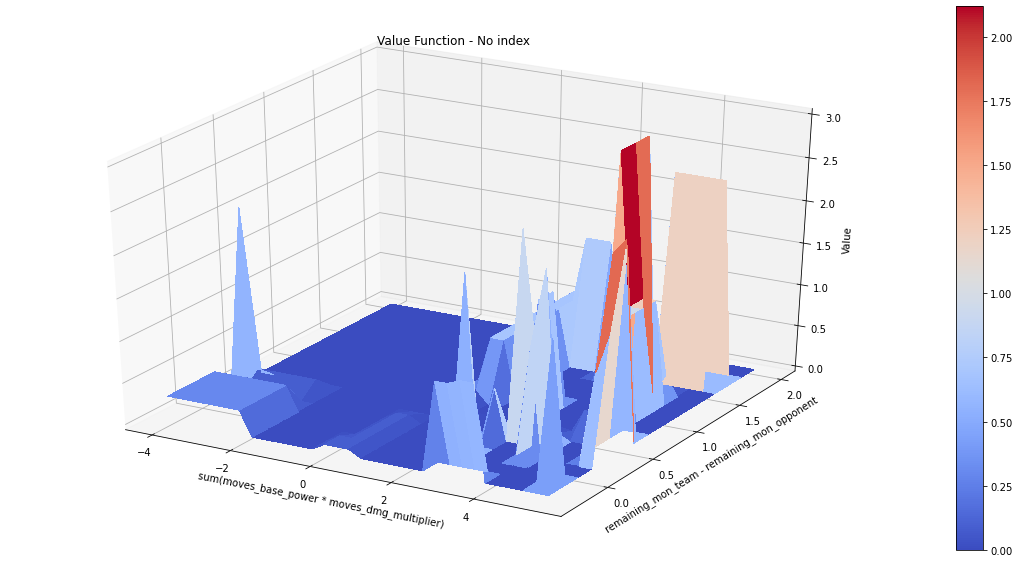

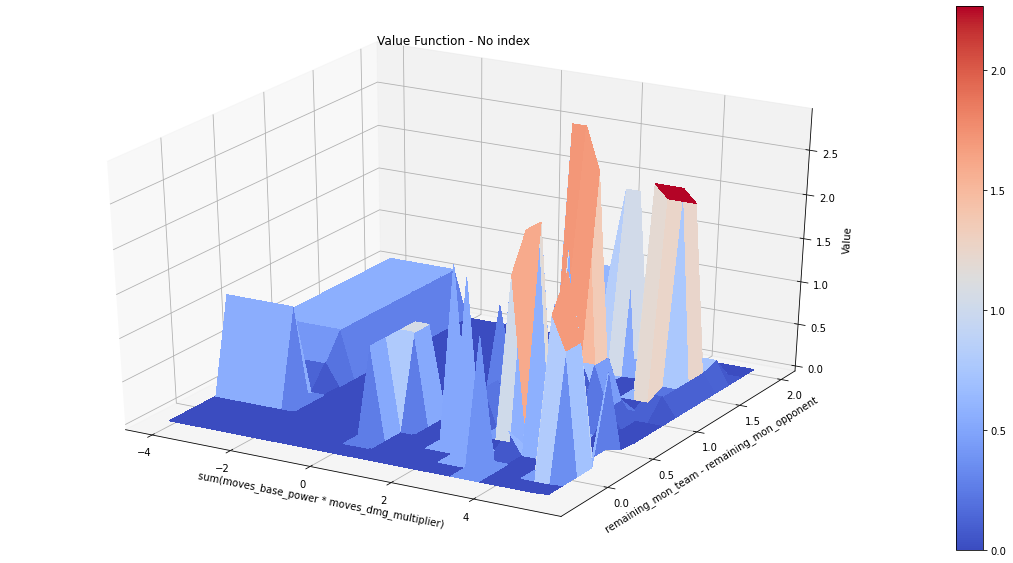

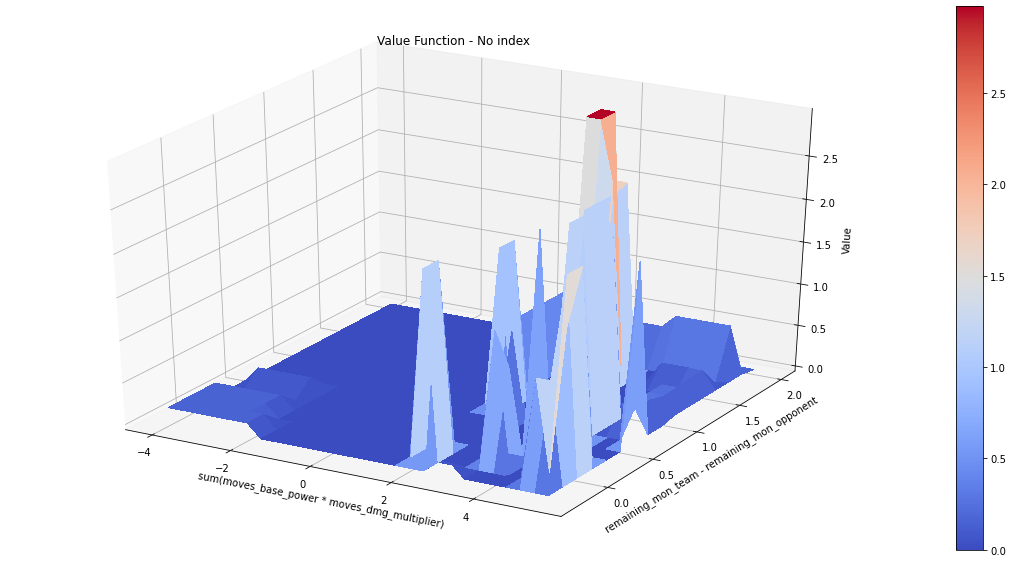

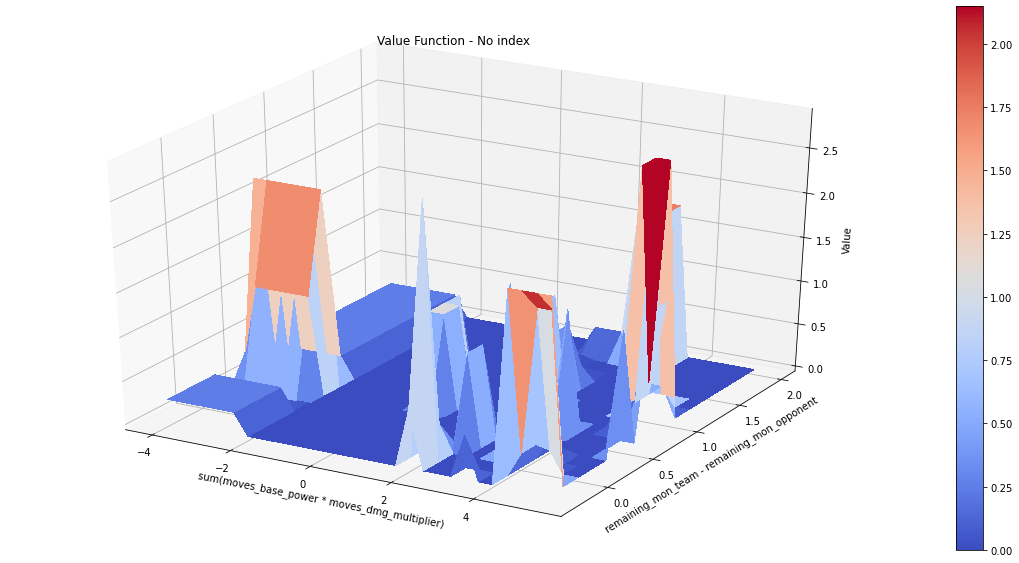

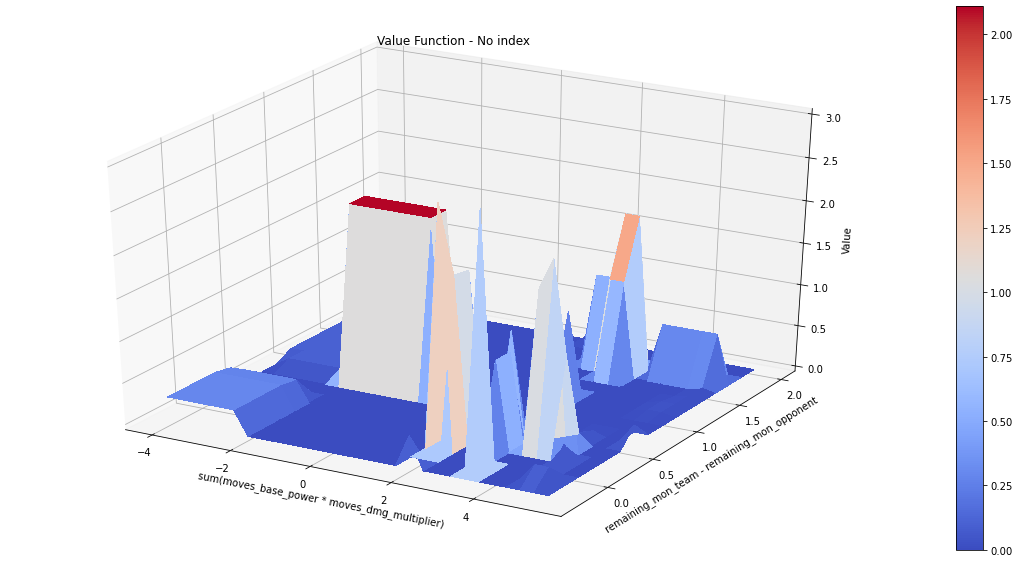

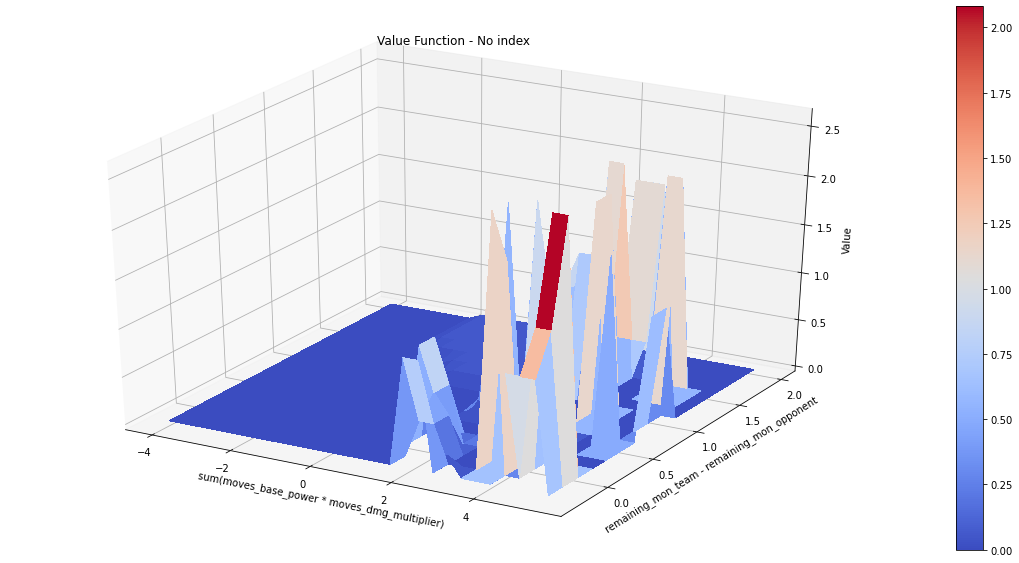

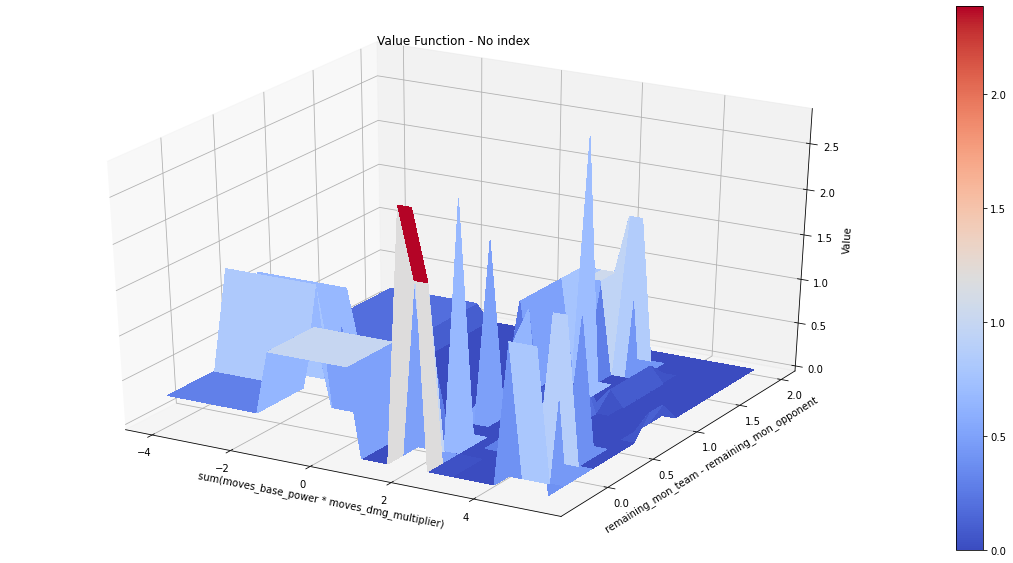

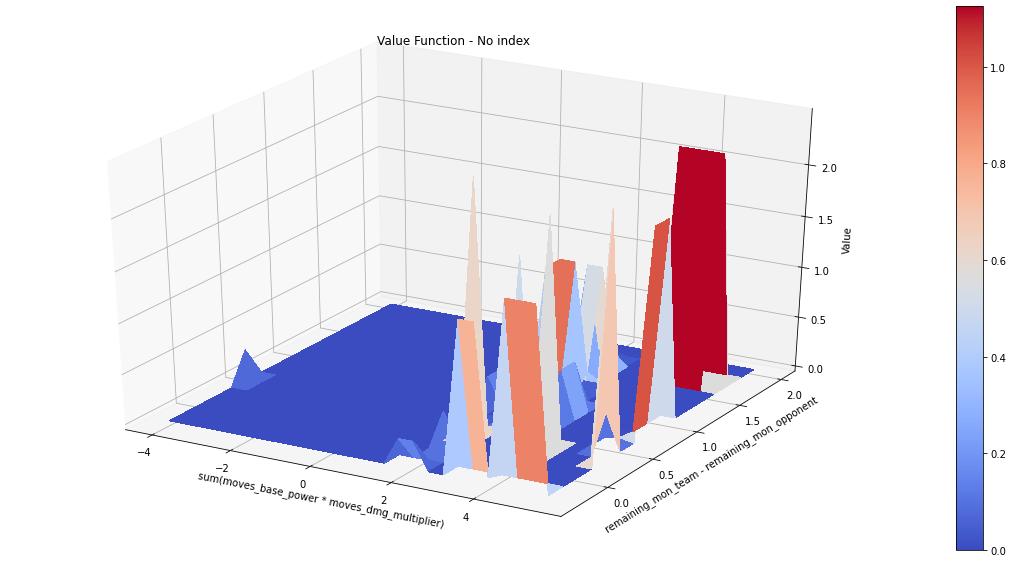

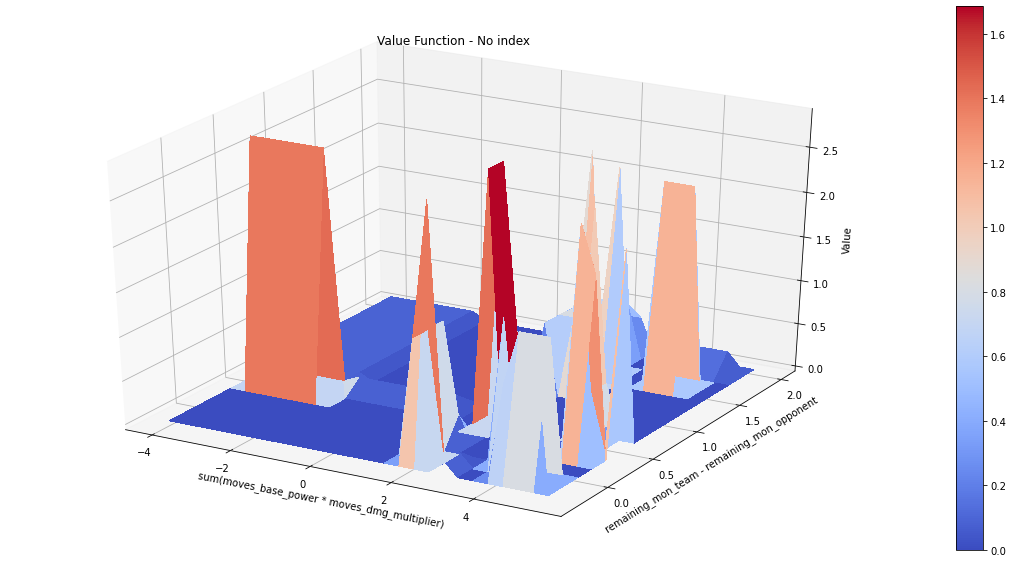

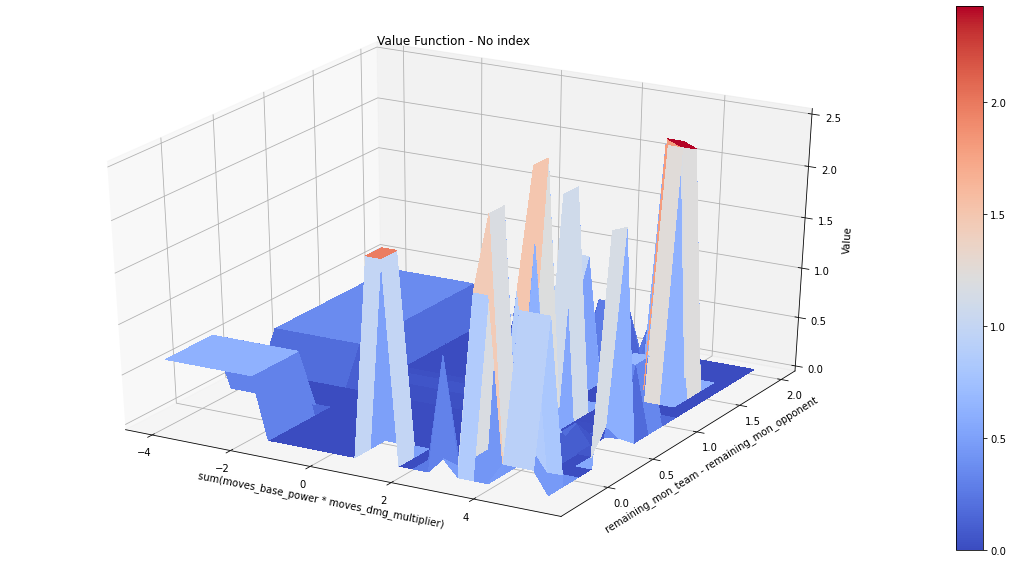

2021-10-10 13:54:17,109 - MaxDamagePlayer 1 - WARNING - Trying to login as MaxDamagePlayer 1, showdown returned  MaxDamagePlayer 1@! - this might prevent future actions from this agent. Changing the agent's username might solve this problem.--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\logging\__init__.py", line 996, in emit
    stream.write(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\internal\streams\std_stream_capture_logger.py", line 41, in write
    self._logger.log(data)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\logging\logger.py", line 27, in log
    self._run[self._attribute_name].log(msg)
  File "C:\Users\leolellisr\anaconda3\envs\poke_env\lib\site-packages\neptune\new\run.py", line 67, in inner_fun
    raise InactiveRunException(short_id=self._short_id)
neptune.new.exceptions.InactiveRunException: 

----InactiveRunException------

In [63]:
import pandas as pd
from scipy.interpolate import griddata
# create 1D-arrays from the 2D-arrays
for test in tests:
    x_values, y_values, z_values = test["noindex_function"] 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    
    plt.show()

In [ ]:
# Too slow and i think is not correct
"""
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
xv, yv = np.meshgrid(x_plot, y_plot)
surf = ax.plot_surface(xv, yv, z_plot, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0, 
                                antialiased=False)
ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
ax.set_zlabel('Value')
ax.set_title('Value Function')
fig.colorbar(surf)
plt.show()
"""

In [59]:
#plot_value_function(V, title="Optimal Value Function")

In [6]:
# Verify policy. Have to change the observation of Q and N
#print("Q: ", env_player.Q['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'])
#print("N: ", env_player.N['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'])
#greedy_action = np.argmax(env_player.Q['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'])
#dim=env_player.Q['0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'].shape
#observation = '0.65 0.7 0.95 0.7 2.0 2.0 1.0 2.0 0.5 0.33'
#env_player.N[observation]
#ep = (0.1/(0.1+np.sum(env_player.N[observation])))
#probs = np.full(dim, ep / dim[0])
#probs
#greedy_action = np.argmax(env_player.Q[observation])
#probs[greedy_action] += 1 - (0.1/(0.1+np.sum(env_player.N[observation]))) 
#print(probs)
#print(env_player.policy(observation))


In [ ]:
# Methods for deterministic player (we have to define teams and perform team preview)

# We evaluate the performance on mon_a against mon_b as its type advantage
    def teampreview_performance(self, mon_a, mon_b):    
        a_on_b = b_on_a = -np.inf
        for type_ in mon_a.types:
            if type_:
                a_on_b = max(a_on_b, type_.damage_multiplier(*mon_b.types))
        # We do the same for mon_b over mon_a
        for type_ in mon_b.types:
            if type_:
                b_on_a = max(b_on_a, type_.damage_multiplier(*mon_a.types))
        # Our performance metric is the different between the two
        return a_on_b - b_on_a    
    
    # Teampreview (Before battle starts)
    def teampreview(self, battle):
        mon_performance = {}

        # For each of our pokemons
        for i, mon in enumerate(battle.team.values()):
            # We store their average performance against the opponent team
            mon_performance[i] = np.mean(
                [
                    self.teampreview_performance(mon, opp)
                    for opp in battle.opponent_team.values()
                ]
            )

        # We sort our mons by performance
        ordered_mons = sorted(mon_performance, key=lambda k: -mon_performance[k])

        # We start with the one we consider best overall
        # We use i + 1 as python indexes start from 0
        #  but showdown's indexes start from 1
        return "/team " + "".join([str(i + 1) for i in ordered_mons])